# Multilayer QG

In [10]:
import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.config import config
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import einops
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat, reduce
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float

from jaxsw._src.domain.base import Domain
from jaxsw._src.operators.functional import advection as F_adv
from jaxsw._src.operators.functional import geostrophic as F_geos
from jaxsw._src.operators.functional import cgrid as F_cgrid
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.boundaries.helmholtz import enforce_boundaries_helmholtz
from jaxsw._src.models import qg_louis as F_qgml

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
config.update("jax_enable_x64", True)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from loguru import logger


def plot_field(field):
    num_axis = len(field)
    fig, ax = plt.subplots(ncols=num_axis, figsize=(8, 3))

    for i in range(num_axis):
        pts = ax[i].pcolormesh(field[i], cmap="coolwarm")
        plt.colorbar(pts)

    plt.tight_layout()
    plt.show()


def print_debug_quantity(quantity, name=""):
    size = quantity.shape
    min_ = np.min(quantity)
    max_ = np.max(quantity)
    mean_ = np.mean(quantity)
    median_ = np.mean(quantity)
    logger.debug(
        f"{name}: {size} | {min_:.6e} | {mean_:.6e} | {median_:.6e} | {max_:.6e}"
    )

In this problem, we are looking at sea surface height (SSH) in relation to the Quasi-Geostrophic (QG) equations. These equations are a simplified form for the Navier-Stokes equations with approximations like *hydrostatic approximation*, *small aspect ratio*, and a *small Rossby number*. Ideally, these equations might be a decent approximation at mesoscale (100km - 10,000km). In this application, we will see how SSH propagates with the QG equations.

## Equations


$$
\partial_t q_k + (u_kq_k)_x + (v_kq_k)_y = F_k + D_k
$$ (eq:qg_form_adv)

The term that links each of the layers together, $\mathbf{A}$, is a tri-diagonal matrix that can be written as

$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_2'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In the paper [[Thiry et al., 2023](https://doi.org/10.22541/essoar.167397445.54992823/v1)], they use the following method

$$
\begin{aligned}
\text{Hyperviscosity}: && 
\boldsymbol{D_1} &= 
-a_4\boldsymbol{\nabla}_H^6\psi\\
\text{Wind Forcing}: && 
\boldsymbol{F} &= 
\frac{\tau_0}{\rho_0H_1}\left[\partial_x\tau_y - \partial_y\tau_x, 0\cdots,0\right]\\
\text{Bottom Drag}: && 
\boldsymbol{D_2} &= 
\frac{\delta_{ek}}{2H_{N_Z}}
\left[0,\cdots,0,\Delta\psi_N\right]
\end{aligned}
$$

Source:
* [Geophysical Fluid Dynamcis - Pedlosky](https://doi.org/10.1007/978-1-4612-4650-3)
* [Atmosphere and Oceanic Fluid Dynamics - Vallis](https://doi.org/10.1017/9781107588417)

## Domain

In [12]:
import typing as tp

params = F_qgml.PDEParams()

In [13]:
# Low Resolution
Nx, Ny = 97, 121
# High Resolution
Lx, Ly = 3840.0e3, 4800.0e3

# initialize domain
# domain = Domain.from_numpoints(xmin=(0, 0), xmax=(Lx, Ly), N=(Nx+1, Ny+1))
domain = F_qgml.Domain(nx=Nx, ny=Ny, Lx=Lx, Ly=Ly)

domain.dx

40000.0

### Heights


$$
\mathbf{A} =
\begin{bmatrix}
\frac{1}{H_1 g_1'} & \frac{-1}{H_1 g_2'} & \ldots & \ldots & \ldots  \\
\frac{-1}{H_2 g_1'} & \frac{1}{H_1}\left(\frac{1}{g_1'} + \frac{1}{g_2'} \right) & \frac{-1}{H_2 g_2'} & \ldots & \ldots  \\
\ldots & \ldots & \ldots & \ldots & \ldots \\
\ldots & \ldots & \frac{-1}{H_{n-1} g_{n-2}'} & \frac{1}{H_{n-1}}\left(\frac{1}{g_{n-2}'} + \frac{1}{g_{n-1}'} \right) & \frac{-1}{H_{n-1} g_{n-2}'}  \\
\ldots & \ldots& \ldots & \frac{-1}{H_n g_{n-1}'} & \frac{1}{H_n g_{n-1}'}   \\
\end{bmatrix}
$$ (eq:qg_A)

In [14]:
# heights
heights = [350.0, 750.0, 2900.0]

num_heights = len(heights)

# reduced gravities
reduced_gravities = [0.025, 0.0125]

A_mat = F_qgml.MLQGHeightMatrix(heights, reduced_gravities)

A_mat()

Array([[ 0.11428571, -0.11428571,  0.        ],
       [-0.05333333,  0.16      , -0.10666667],
       [ 0.        , -0.02758621,  0.02758621]], dtype=float64)

In [15]:
A_mat.lambd, A_mat.A_layer_2_mode, A_mat.A_mode_2_layer

(Array([ 2.28183707e-01,  7.36882145e-02, -4.04361683e-18], dtype=float64),
 Array([[-0.43193138,  0.92242719, -0.49049581],
        [-0.65802762, -0.50089268,  1.15892029],
        [-0.15155445, -0.32475953, -1.25573684]], dtype=float64),
 Array([[-0.70499319, -0.92396019, -0.57735027],
        [ 0.70260146, -0.32821664, -0.57735027],
        [-0.09662189,  0.19639605, -0.57735027]], dtype=float64))

### Helmholtz Matrices

We can precompute the Helmoltz matrices

$$
\text{Helmholtz}:=\left(\alpha\boldsymbol{\nabla}-\beta\right)u
$$

In [16]:
from jaxsw._src.operators.functional import elliptical as F_elliptical

In [17]:
# compute Laplacian Matrix from DST
alpha = 1 / params.f0**2
beta = einops.repeat(A_mat.lambd, "Nz -> Nz 1 1")
# mean = True
# laplace_dst = alpha * F_elliptical.laplacian_dst(nx=domain.size[0], ny=domain.size[1], dx=domain.dx[0], dy=domain.dx[1], mean=mean)
# print_debug_quantity(laplace_dst)

# helmoltz_dst_mat = laplace_dst  - beta


# print_debug_quantity(helmoltz_dst_mat[0])
# print_debug_quantity(helmoltz_dst_mat[1])
# print_debug_quantity(helmoltz_dst_mat[2])
helmoltz_dst_mat = F_elliptical.helmholtz_dst(
    nx=domain.nx, ny=domain.ny, dx=domain.dx, dy=domain.dy, alpha=alpha, beta=beta
)
print_debug_quantity(helmoltz_dst_mat[0])
print_debug_quantity(helmoltz_dst_mat[1])
print_debug_quantity(helmoltz_dst_mat[2])

2023-07-11 20:04:40.029 | DEBUG    | __main__:print_debug_quantity:20 - : (95, 119) | -7.969477e-01 | -5.126282e-01 | -5.126282e-01 | -2.283086e-01
2023-07-11 20:04:40.032 | DEBUG    | __main__:print_debug_quantity:20 - : (95, 119) | -6.424522e-01 | -3.581327e-01 | -3.581327e-01 | -7.381310e-02
2023-07-11 20:04:40.034 | DEBUG    | __main__:print_debug_quantity:20 - : (95, 119) | -5.687640e-01 | -2.844445e-01 | -2.844445e-01 | -1.248847e-04


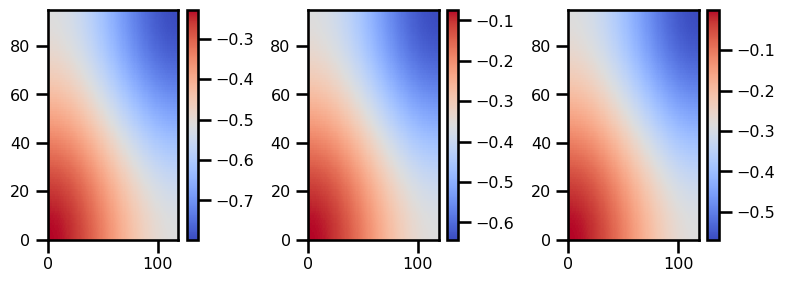

In [18]:
plot_field(helmoltz_dst_mat)

### Inversion

In [19]:
# # constant field
# constant_field = jnp.ones((A_mat.Nz, domain.size[0], domain.size[1])) / (domain.size[0] * domain.size[1])
# print_debug_quantity(constant_field)
# #
# s_solutions = jnp.zeros_like(constant_field)
# out = jax.vmap(F_elliptical.inverse_elliptic_dst, in_axes=(0,0))(constant_field[:, 1:-1,1:-1], helmoltz_dst_mat)
# s_solutions = s_solutions.at[:, 1:-1, 1:-1].set(out)
# print_debug_quantity(s_solutions[0])
# print_debug_quantity(s_solutions[1])
# print_debug_quantity(s_solutions[2])

# # homogeneous solution
# # ignore last solution correponding to lambd = 0, i.e. Laplace equation
# homogeneous_sol = (constant_field + s_solutions * beta)[:-1]

# print_debug_quantity(homogeneous_sol)

In [20]:
homogeneous_sol = F_qgml.homogeneous_sol_layers(helmoltz_dst_mat, domain, A_mat)
print_debug_quantity(homogeneous_sol)

2023-07-11 20:04:42.504 | DEBUG    | __main__:print_debug_quantity:20 - : (2, 97, 121) | -3.576361e-12 | 4.449322e-06 | 4.449322e-06 | 8.520065e-05


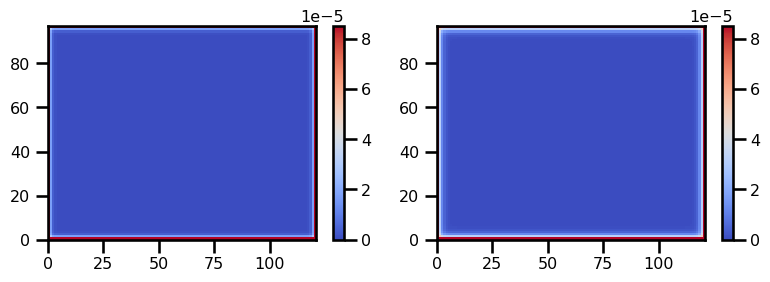

In [21]:
plot_field(homogeneous_sol)

### Alpha Matrix

In [22]:
alpha_matrix = F_qgml.compute_alpha_matrix(A_mat.A_mode_2_layer, homogeneous_sol)

print_debug_quantity(alpha_matrix)

2023-07-11 20:04:45.072 | DEBUG    | __main__:print_debug_quantity:20 - : (2, 2) | -2.558977e+05 | -1.140663e+05 | -1.140663e+05 | 2.813377e-11


## Forcing

In [23]:
# def init_tau(domain, tau0: float=2.0e-5):
#     """
#     Args
#     ----
#         tau0 (float): wind stress magnitude m/s^2
#             default=2.0e-5"""
#     # initial TAU
#     tau = np.zeros((2, domain.nx, domain.ny))

#     # create staggered coordinates (y-direction)
#     y_coords = np.arange(domain.ny) + 0.5

#     # create tau
#     tau[0, :, :] = - tau0 * np.cos(2 * np.pi * (y_coords / domain.ny))

#     return tau

# def calculate_wind_forcing(tau, domain):
#     # move from edges to nodes
#     tau_x = F_grid.x_average_2D(tau[0])
#     tau_y = F_grid.y_average_2D(tau[1])

#     # calculate curl
#     dF2dX = (tau_y[1:] - tau_y[:-1]) / domain.dx
#     dF1dY = (tau_x[:,1:] - tau_x[:,:-1]) / domain.dy
#     curl_stagg = dF2dX - dF1dY

#     # move from nodes to faces
#     return F_grid.center_average_2D(curl_stagg)

tau = F_qgml.init_tau(domain, tau0=2.0e-5)
print_debug_quantity(tau, "Tau")
wind_forcing = F_qgml.calculate_wind_forcing(tau, domain) / (params.f0 * heights[0])
print_debug_quantity(wind_forcing, "wind_forcing")

2023-07-11 20:04:45.840 | DEBUG    | __main__:print_debug_quantity:20 - Tau: (2, 97, 121) | -1.999326e-05 | 3.348584e-22 | 3.348584e-22 | 2.000000e-05
2023-07-11 20:04:46.404 | DEBUG    | __main__:print_debug_quantity:20 - wind_forcing: (95, 119) | -7.908487e-10 | -9.833974e-26 | -9.833974e-26 | 7.908487e-10


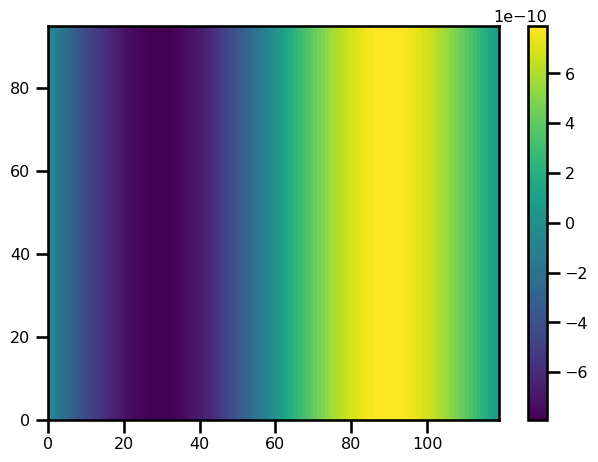

In [24]:
fig, ax = plt.subplots()

pts = ax.pcolormesh(wind_forcing)
plt.colorbar(pts)

plt.tight_layout()
plt.show()

## Vorticity

In [25]:
# lap_fn = lambda x: fdx.laplacian(x, step_size=domain.dx, accuracy=1, method="central")
# lap_p = jax.vmap(lap_fn)(p)
# print_debug_quantity(lap_p, "LAPLACIAN")
# lap_p_ = laplacian(p, params.zfbc) / (domain.dx**2)
# print_debug_quantity(lap_p_, "LAPLACIAN")

In [26]:
# plot_field(lap_p)
# plot_field(lap_p_)
# plot_field(np.abs(lap_p_ - lap_p))

In [27]:
# lap_fn = lambda x: fdx.laplacian(x, step_size=domain.dx, accuracy=1, method="central")
# lap_p = jax.vmap(lap_fn)(p)
# bcs = F_qgml.laplacian_boundaries(lap_p, params.zfbc / (domain.dx**2))
# lap_p = F_qgml._apply_boundaries(lap_p, bcs)
# print_debug_quantity(lap_p, "LAPLACIAN")
# lap_p_ = laplacian(p, params.zfbc)
# lap_p_ = lap_p_ / (domain.dx**2)
# print_debug_quantity(lap_p_, "LAPLACIAN")

In [28]:
# plot_field(lap_p)
# plot_field(lap_p_)
# plot_field(np.abs(lap_p_ - lap_p))

In [29]:
p = np.load("./p_380yrs_HRDS.npy", allow_pickle=True).astype(np.float64)
print_debug_quantity(p, "PRESSURE")
q = F_qgml.pressure_to_vorticity(p, A_mat(), domain, params)
print_debug_quantity(q, "VORTICITY")

2023-07-11 20:04:48.243 | DEBUG    | __main__:print_debug_quantity:20 - PRESSURE: (3, 97, 121) | -4.332182e+00 | 3.335592e-02 | 3.335592e-02 | 3.561408e+00
2023-07-11 20:04:48.422 | DEBUG    | __main__:print_debug_quantity:20 - VORTICITY: (3, 97, 121) | -4.657202e-01 | -6.788409e-06 | -6.788409e-06 | 4.963626e-01


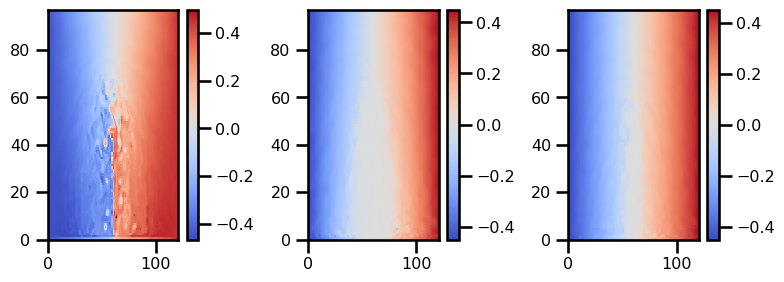

In [30]:
plot_field(q)

## RHS

### Determinant Jacobian

In [31]:
## discrete spatial differential operators
def jacobi_h(f, g):
    """Arakawa discretisation of Jacobian J(f,g).
    Scalar fields f and g must have the same dimension.
    Grid is regular and dx = dy."""
    dx_f = f[..., 2:, :] - f[..., :-2, :]
    dx_g = g[..., 2:, :] - g[..., :-2, :]
    dy_f = f[..., 2:] - f[..., :-2]
    dy_g = g[..., 2:] - g[..., :-2]
    return (
        (dx_f[..., 1:-1] * dy_g[..., 1:-1, :] - dx_g[..., 1:-1] * dy_f[..., 1:-1, :])
        + (
            (
                f[..., 2:, 1:-1] * dy_g[..., 2:, :]
                - f[..., :-2, 1:-1] * dy_g[..., :-2, :]
            )
            - (f[..., 1:-1, 2:] * dx_g[..., 2:] - f[..., 1:-1, :-2] * dx_g[..., :-2])
        )
        + (
            (g[..., 1:-1, 2:] * dx_f[..., 2:] - g[..., 1:-1, :-2] * dx_f[..., :-2])
            - (
                g[..., 2:, 1:-1] * dy_f[..., 2:, :]
                - g[..., :-2, 1:-1] * dy_f[..., :-2, :]
            )
        )
    ) / 12.0

In [32]:
rhs = 1.0 / (params.f0 * domain.dx * domain.dy) * F_qgml.det_jacobian(q, p)
print_debug_quantity(rhs, "RHS DET JACOBIAN")

2023-07-11 20:04:50.259 | DEBUG    | __main__:print_debug_quantity:20 - RHS DET JACOBIAN: (3, 95, 119) | -1.564097e-06 | -1.405445e-12 | -1.405445e-12 | 1.195297e-06


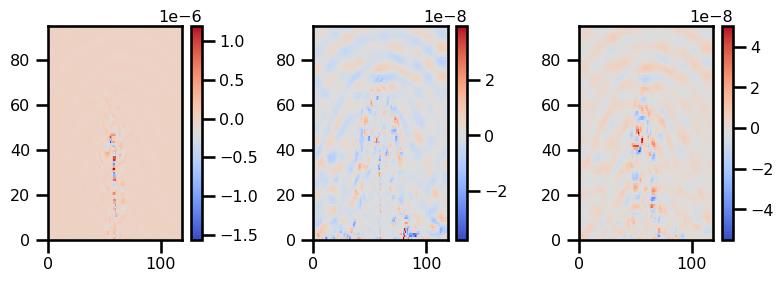

In [33]:
plot_field(rhs)

### Extra Terms

In [34]:
def diffusion_term(p, params, domain):
    return params.a_2 / params.f0**2 / domain.dx**4 * F_qgml.laplacian_interior(p)


def hyperdiffusion_term(p, params, domain):
    return (
        -(params.a_4 / params.f0**2)
        / domain.dx**6
        * F_qgml.laplacian_interior(F_qgml.laplacian(p, params.zfbc))
    )


def bottom_friction(p, params, domain, height_params):
    return (
        params.delta_ek
        / (2 * np.abs(params.f0) * domain.dx**2 * (-height_params.heights[-1]))
        * F_qgml.laplacian_interior(p[..., -1:, :, :])
    )

In [35]:
p_diff = p

# calculate
delta2_p = F_qgml.laplacian(p_diff, params.zfbc)
print_debug_quantity(delta2_p, "Laplacian Term")
if params.a_2 != 0.0:
    diff_term = diffusion_term(delta2_p, params, domain)
    print_debug_quantity(diff_term, "Diffusion Term")
    rhs += diff_term
if params.a_4 != 0.0:
    hyperdiff_term = hyperdiffusion_term(delta2_p, params, domain)
    print_debug_quantity(hyperdiff_term, "Diffusion Term")
    rhs += hyperdiff_term

print_debug_quantity(wind_forcing, "WIND FORCING")
rhs = rhs.at[..., 0:1, :, :].set(rhs[..., 0:1, :, :] + wind_forcing)
bottom_term = bottom_friction(p, params, domain, A_mat)
print_debug_quantity(bottom_term, "Bottom Friction")
rhs = rhs.at[..., -1:, :, :].set(rhs[..., -1:, :, :] + bottom_term)

2023-07-11 20:04:51.861 | DEBUG    | __main__:print_debug_quantity:20 - Laplacian Term: (3, 97, 121) | -2.852461e+00 | -9.280515e-05 | -9.280515e-05 | 3.835035e+00
2023-07-11 20:04:51.904 | DEBUG    | __main__:print_debug_quantity:20 - Diffusion Term: (3, 95, 119) | -7.209133e-07 | -4.914557e-12 | -4.914557e-12 | 6.775439e-07
2023-07-11 20:04:51.905 | DEBUG    | __main__:print_debug_quantity:20 - WIND FORCING: (95, 119) | -7.908487e-10 | -9.833974e-26 | -9.833974e-26 | 7.908487e-10
2023-07-11 20:04:52.021 | DEBUG    | __main__:print_debug_quantity:20 - Bottom Friction: (1, 95, 119) | -1.221567e-09 | 4.609835e-13 | 4.609835e-13 | 1.503295e-09


### Full RHS

In [36]:
def advection_rhs(q, p, params, domain):
    # Calculate Determinant Jacobian
    rhs = 1.0 / (params.f0 * domain.dx * domain.dy) * F_qgml.det_jacobian(q, p)

    # calculate Laplacian
    delta2_p = F_qgml.laplacian(p_diff, params.zfbc)

    # Add Diffusion Term
    if params.a_2 != 0.0:
        rhs += diffusion_term(delta2_p, params, domain)

    # Add HyperDiffusion
    if params.a_4 != 0.0:
        rhs += hyperdiffusion_term(delta2_p, params, domain)

    # Add Wind Forcing
    rhs = rhs.at[..., 0:1, :, :].set(rhs[..., 0:1, :, :] + wind_forcing)

    # Add Bottom Friction
    rhs = rhs.at[..., -1:, :, :].set(rhs[..., -1:, :, :] + bottom_term)

    return rhs

In [37]:
rhs = advection_rhs(q, p, params, domain)
print_debug_quantity(rhs, "RHS")

2023-07-11 20:04:53.436 | DEBUG    | __main__:print_debug_quantity:20 - RHS: (3, 95, 119) | -1.502200e-06 | -6.166340e-12 | -6.166340e-12 | 1.339342e-06


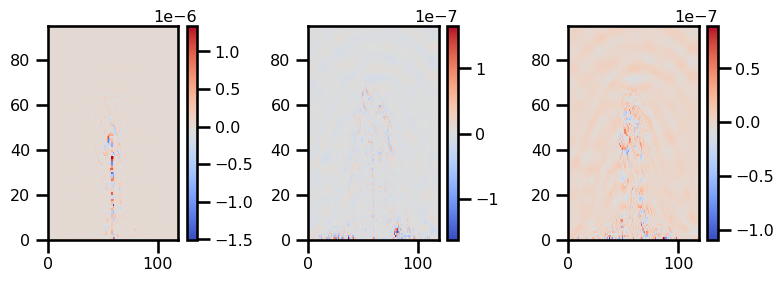

In [38]:
plot_field(rhs)

In [39]:
import functools as ft

rhs_fn = ft.partial(advection_rhs, params=params, domain=domain)
rhs_jitted = jax.jit(rhs_fn)

In [40]:
# %timeit out = rhs_fn(q, p)
# %timeit out = rhs_jitted(q, p)

In [41]:
rhs_fn(q, p).shape

(3, 95, 119)

In [42]:
def rhs_pde(q, p, params, A_mat, domain):
    # calculate advection - interior only
    dq_f0 = advection_rhs(q, p, params, domain)
    # pad - original domain
    dq_f0 = jnp.pad(dq_f0, ((0, 0), (1, 1), (1, 1)))

    # pressure
    rhs_helmholtz = jnp.einsum("ij,jkl->ikl", A_mat.A_layer_2_mode, dq_f0)
    dp_modes = jax.vmap(F_elliptical.inverse_elliptic_dst, in_axes=(0, 0))(
        rhs_helmholtz[:, 1:-1, 1:-1], helmoltz_dst_mat
    )
    # pad - original domain
    dp_modes = jnp.pad(dp_modes, ((0, 0), (1, 1), (1, 1)))

    # ensure mass conservation
    dalpha = alpha_matrix @ dp_modes[..., :-1, :, :].mean((-2, -1))
    dalpha = einops.repeat(dalpha, "i -> i 1 1")
    dp_modes = dp_modes.at[..., :-1, :, :].set(
        dp_modes[..., :-1, :, :] + dalpha * homogeneous_sol
    )
    dp = jnp.einsum("ij,jkl->ikl", A_mat.A_mode_2_layer, dp_modes)

    # UPDATE VORTICITY @ BOUNDARIES
    delta_p_boundaries = F_qgml.laplacian_boundaries(
        dp / (params.f0 * domain.dx) ** 2, params.zfbc
    )
    dp_boundaries = jnp.concatenate(
        [dp[..., 0, 1:-1], dp[..., -1, 1:-1], dp[..., :, 0], dp[..., :, -1]], axis=-1
    )
    dq_f0_boundaries = delta_p_boundaries - A_mat.A @ dp_boundaries

    dq_f0 = F_qgml._apply_boundaries(dq_f0, dq_f0_boundaries)

    return dq_f0, dp


dq_f0, dp = rhs_pde(q, p, params, A_mat, domain)
print_debug_quantity(dp, "dp")
print_debug_quantity(dq_f0, "dq_f0")

2023-07-11 20:04:55.638 | DEBUG    | __main__:print_debug_quantity:20 - dp: (3, 97, 121) | -5.169436e-06 | 2.948032e-08 | 2.948032e-08 | 5.236780e-06
2023-07-11 20:04:55.639 | DEBUG    | __main__:print_debug_quantity:20 - dq_f0: (3, 97, 121) | -1.502200e-06 | -8.475099e-12 | -8.475099e-12 | 1.339342e-06


In [61]:
rhs_pde_jitted = jax.jit(rhs_pde, static_argnames=("params", "A_mat", "domain"))


# vector field
def vector_field(t, state, args):
    q, p = state
    q, p = rhs_pde_jitted(q, p, params, A_mat, domain)

    return (q, p)


p = np.load("./p_380yrs_HRDS.npy", allow_pickle=True).astype(np.float64)
print_debug_quantity(p, "PRESSURE")
q = F_qgml.pressure_to_vorticity(p, A_mat(), domain, params)
print_debug_quantity(q, "VORTICITY")

state = (q, p)
args = (params, A_mat, domain)

2023-07-11 20:11:09.980 | DEBUG    | __main__:print_debug_quantity:20 - PRESSURE: (3, 97, 121) | -4.332182e+00 | 3.335592e-02 | 3.335592e-02 | 3.561408e+00
2023-07-11 20:11:09.993 | DEBUG    | __main__:print_debug_quantity:20 - VORTICITY: (3, 97, 121) | -4.657202e-01 | -6.788409e-06 | -6.788409e-06 | 4.963626e-01


In [62]:
dq_f0, dp = vector_field(0, state, args)
print_debug_quantity(dp, "dp")
print_debug_quantity(dq_f0, "dq_f0")

2023-07-11 20:11:18.931 | DEBUG    | __main__:print_debug_quantity:20 - dp: (3, 97, 121) | -5.169436e-06 | 2.948032e-08 | 2.948032e-08 | 5.236780e-06
2023-07-11 20:11:18.932 | DEBUG    | __main__:print_debug_quantity:20 - dq_f0: (3, 97, 121) | -1.502200e-06 | -8.475099e-12 | -8.475099e-12 | 1.339342e-06


In [63]:
dt = 1_200  # LR # 600 # HR
n_years = 2
n_days = 365
tmin = 0
tmax = pd.to_timedelta(n_years * n_days, unit="day").total_seconds()
ts = jnp.arange(tmin, tmax, dt)

In [64]:
len(ts)

52560

In [65]:
solver = dfx.Heun()
solver_state = solver.init(
    terms=dfx.ODETerm(vector_field),
    t0=tmax,
    t1=tmin + dt,
    y0=state,
    args=args,
)

In [72]:
n_check = 1_000 * dt
n_check

1200000

In [73]:
with tqdm(ts) as pbar:
    for t in pbar:
        state, _, _, solver_state, _ = solver.step(
            terms=dfx.ODETerm(vector_field),
            t0=t,
            t1=t + dt,
            y0=state,
            args=args,
            solver_state=solver_state,
            made_jump=False,
        )
        msg1 = f"PRESSURE: {jnp.min(state[0]):.4e} | {jnp.max(state[0]):.4e}"
        msg2 = f"VORTICITY: {jnp.min(state[1]):.4e} | {jnp.max(state[1]):.4e}"
        pbar.set_description(msg1 + " - " + msg2)

        if t > n_check:
            pbar.set_description("STOPPING!")
            break

  0%|          | 0/52560 [00:00<?, ?it/s]

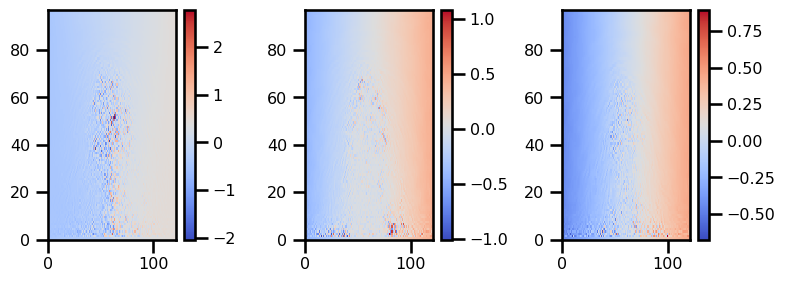

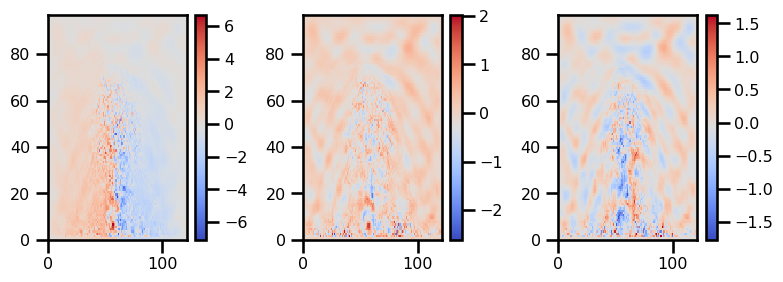

In [74]:
plot_field(state[0])
plot_field(state[1])

In [150]:
# advect vorticity inside the domain
dq_over_f0 = rhs_fn(q, p)
print_debug_quantity(dq_over_f0, "dq_f0")
dq_over_f0 = jnp.pad(dq_over_f0, ((0, 0), (1, 1), (1, 1)))
print_debug_quantity(dq_over_f0, "dq_f0")

# solve helmholtz eq for pressure
rhs_helmholtz = jnp.einsum("ij,jkl->ikl", A_mat.A_layer_2_mode, dq_over_f0)
print_debug_quantity(rhs_helmholtz, "rhs_helmholtz")

dp_modes = jax.vmap(F_elliptical.inverse_elliptic_dst, in_axes=(0, 0))(
    rhs_helmholtz[:, 1:-1, 1:-1], helmoltz_dst_mat
)
dp_modes = jnp.pad(dp_modes, ((0, 0), (1, 1), (1, 1)))
print_debug_quantity(dp_modes, "dp_modes")

# ensure mass convervation
dalpha = alpha_matrix @ dp_modes[..., :-1, :, :].mean((-2, -1))
print_debug_quantity(dalpha, "dalpha")
dalpha = einops.repeat(dalpha, "i -> i 1 1")
print_debug_quantity(dalpha, "dalpha")

2023-07-11 19:22:46.137 | DEBUG    | __main__:print_debug_quantity:20 - dq_f0: (3, 95, 119) | -1.502200e-06 | -6.166340e-12 | -6.166340e-12 | 1.339342e-06
2023-07-11 19:22:46.138 | DEBUG    | __main__:print_debug_quantity:20 - dq_f0: (3, 97, 121) | -1.502200e-06 | -5.939378e-12 | -5.939378e-12 | 1.339342e-06
2023-07-11 19:22:46.139 | DEBUG    | __main__:print_debug_quantity:20 - rhs_helmholtz: (3, 97, 121) | -8.917592e-07 | 1.125180e-12 | 1.125180e-12 | 9.745410e-07
2023-07-11 19:22:46.153 | DEBUG    | __main__:print_debug_quantity:20 - dp_modes: (3, 97, 121) | -4.214963e-06 | -1.693218e-08 | -1.693218e-08 | 3.790947e-06
2023-07-11 19:22:46.154 | DEBUG    | __main__:print_debug_quantity:20 - dalpha: (2,) | -5.508387e-05 | -2.625952e-05 | -2.625952e-05 | 2.564827e-06
2023-07-11 19:22:46.184 | DEBUG    | __main__:print_debug_quantity:20 - dalpha: (2, 1, 1) | -5.508387e-05 | -2.625952e-05 | -2.625952e-05 | 2.564827e-06
